In [7]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Downloads NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Carregando o dataset (Section 1: Dataset)
df = pd.read_excel('BBC.xlsx')  # Verifique o formato e o nome correto do arquivo

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Henri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Henri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Henri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Pré-processamento de texto (Section 2: Classification pipeline)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
blacklist = ['said']

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words and word not in blacklist]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

# Vetorização TF-IDF para melhorar a qualidade da representação dos textos
vectorizer = TfidfVectorizer(max_features=5000)  # Limitando a 5000 palavras para otimizar performance
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Dividindo os dados para treino e teste 
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['category'], test_size=0.2, stratify=df['category'], random_state=42)

# Definindo os modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB()
}

# Função para treinar e avaliar o modelo com matrizes de confusão e acurácia balanceada
def train_and_evaluate(model, X_train_tfidf, X_test_tfidf, y_train, y_test, num_iterations=10):
    train_accuracies, test_accuracies = [], []
    balanced_accuracies = []
    conf_matrices = np.zeros((len(df['category'].unique()), len(df['category'].unique())))

    for _ in range(num_iterations):
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X_train_tfidf, y_train, test_size=0.2, stratify=y_train
        )
        
        model.fit(X_train_split, y_train_split)
        
        y_train_pred = model.predict(X_train_split)
        y_test_pred = model.predict(X_test_split)
        
        train_accuracies.append(accuracy_score(y_train_split, y_train_pred))
        test_accuracies.append(accuracy_score(y_test_split, y_test_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test_split, y_test_pred))
        
        conf_matrices += confusion_matrix(y_test_split, y_test_pred)

    mean_train_accuracy = np.mean(train_accuracies)
    mean_test_accuracy = np.mean(test_accuracies)
    mean_balanced_accuracy = np.mean(balanced_accuracies)

    print(f'Mean Training Accuracy: {mean_train_accuracy:.4f}')
    print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')
    print(f'Mean Balanced Accuracy: {mean_balanced_accuracy:.4f}')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrices / num_iterations, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=df['category'].unique(), yticklabels=df['category'].unique())
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def get_top_words_per_category_wordcloud(df, category_label, top_n=5):
    category_text = ' '.join(df[df['category'] == category_label]['clean_text'])
    words = category_text.split()
    word_freq = Counter(words)
    
    top_words = word_freq.most_common(top_n)
    print(f"\nTop {top_n} words for category '{category_label}':")
    print(", ".join([word for word, freq in top_words]))


Logistic Regression Model:
Mean Training Accuracy: 0.9963
Mean Test Accuracy: 0.9713
Mean Balanced Accuracy: 0.9706


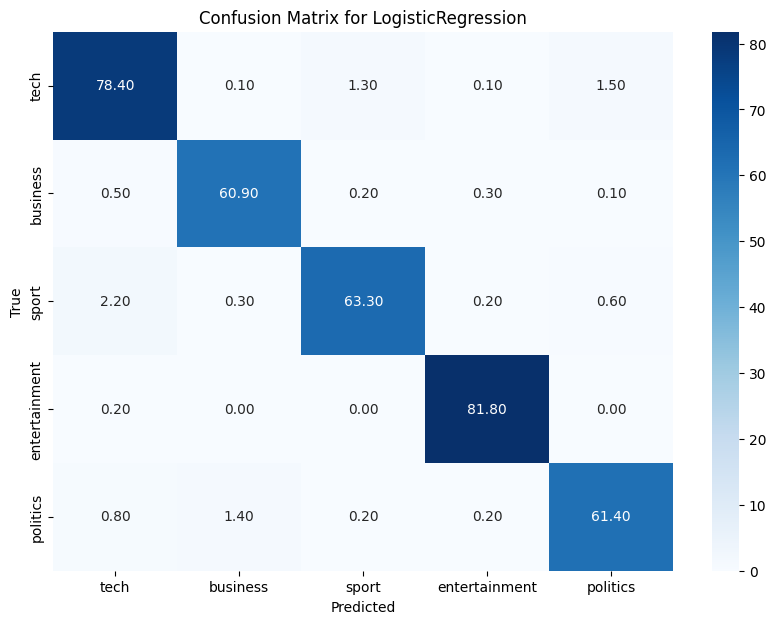


Naive Bayes Model:
Mean Training Accuracy: 0.9864
Mean Test Accuracy: 0.9719
Mean Balanced Accuracy: 0.9709


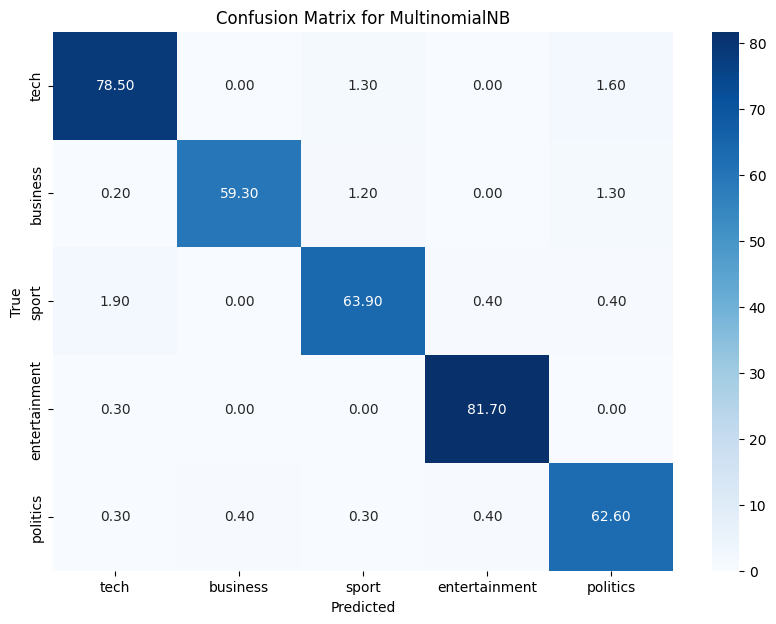

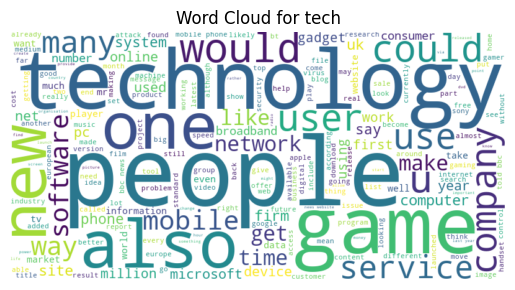

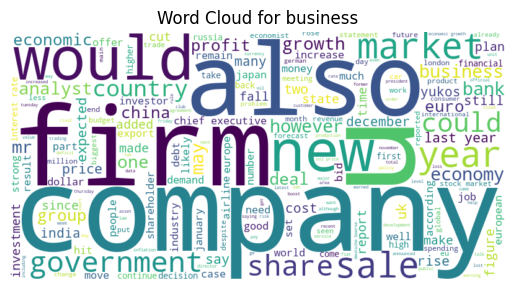

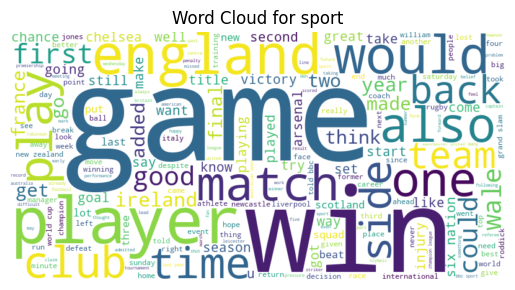

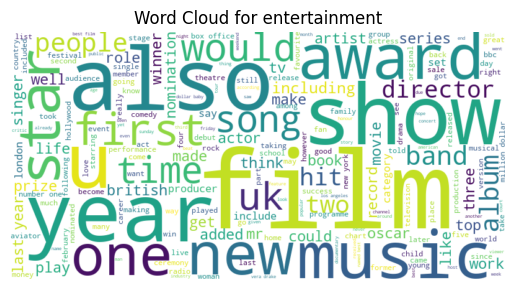

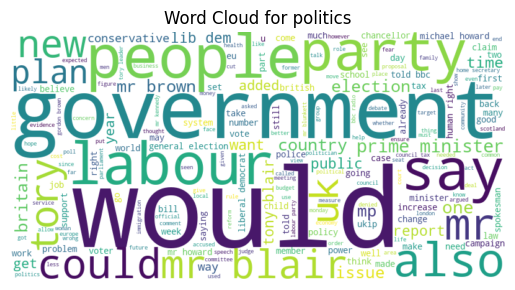


Top 5 words for category 'tech':
people, game, technology, mobile, phone

Top 5 words for category 'business':
year, u, company, mr, firm

Top 5 words for category 'sport':
game, player, win, england, year

Top 5 words for category 'entertainment':
film, year, best, award, music

Top 5 words for category 'politics':
mr, would, labour, government, party


In [9]:
# Avaliação com os modelos definidos (Section 3: Evaluation)
for name, model in models.items():
    print(f"\n{name} Model:")
    train_and_evaluate(model, X_train_tfidf, X_test_tfidf, y_train, y_test, num_iterations=10)

# Análise de Nuvem de Palavras para cada categoria
for category in df['category'].unique():
    text = ' '.join(df[df['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=blacklist).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {category}")
    plt.show()

# Avaliação dos top 5 palavras por categoria
for category in df['category'].unique():
    get_top_words_per_category_wordcloud(df, category)

In [10]:
# Avaliação de desempenho com downsampling do dataset (Section 4: Dataset Size)
sample_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
train_errors, test_errors = [], []

for size in sample_sizes:
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train_tfidf, y_train, train_size=size, stratify=y_train)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_sample, y_train_sample)
    train_errors.append(1 - model.score(X_train_sample, y_train_sample))
    test_errors.append(1 - model.score(X_test_tfidf, y_test))

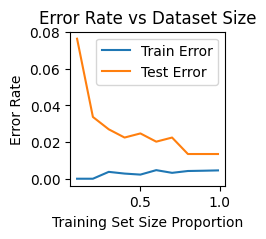

In [11]:
plt.figure(figsize=(2, 2))
plt.plot(sample_sizes, train_errors, label='Train Error')
plt.plot(sample_sizes, test_errors, label='Test Error')
plt.xlabel('Training Set Size Proportion')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Dataset Size')
plt.legend()
plt.show()

In [12]:
# Análise de Tópicos com LDA (Section 5: Topic Analysis)
lda = LatentDirichletAllocation(n_components=5, random_state=42)

# Divisão do dataset ANTES de rodar o LDA, para garantir a consistência
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_tfidf, y_train, test_size=0.4, stratify=y_train)

# Aplicando LDA APÓS a divisão dos dados
X_train_topics = lda.fit_transform(X_train_split)
X_test_topics = lda.transform(X_test_split)

# Análise de Tópicos com LDA (Section 5: Topic Analysis)
lda = LatentDirichletAllocation(n_components=5, random_state=42)

# Divisão do dataset ANTES de rodar o LDA, para garantir a consistência
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_tfidf, y_train, test_size=0.4, stratify=y_train)

# Aplicando LDA APÓS a divisão dos dados
X_train_topics = lda.fit_transform(X_train_split)
X_test_topics = lda.transform(X_test_split)

# Função para imprimir as palavras mais relevantes de cada tópico
def print_words_in_topics(model, vectorizer):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}")
        for i in topic.argsort()[-10:]:
            print(words[i])
        print()
    print()

# Visualizando os tópicos gerados pelo LDA
print_words_in_topics(lda, vectorizer)

# Threshold for assigning topics (documents that don't meet the threshold will be ambiguous)
def assign_topic_with_threshold(topic_distributions, threshold=0.2):
    topic_assignment = []
    for distribution in topic_distributions:
        if np.max(distribution) >= threshold:
            topic_assignment.append(np.argmax(distribution))
        else:
            topic_assignment.append(-1)  # Label as 'ambiguous' if below threshold
    return np.array(topic_assignment)

# Função corrigida para o classificador de duas camadas
def two_layer_classifier(X_train_tfidf, X_train_topics, X_test_tfidf, X_test_topics, y_train, y_test):
    
    # Topic assignment with threshold
    train_topic_assignment = assign_topic_with_threshold(X_train_topics, threshold=0.2)
    test_topic_assignment = assign_topic_with_threshold(X_test_topics, threshold=0.2)

    # Filter out ambiguous samples (-1)
    train_valid_idx = train_topic_assignment != -1
    test_valid_idx = test_topic_assignment != -1

    X_train_valid = X_train_tfidf[train_valid_idx]
    y_train_valid = y_train[train_valid_idx]

    X_test_valid = X_test_tfidf[test_valid_idx]
    y_test_valid = y_test[test_valid_idx]

    ros = RandomOverSampler(random_state=42)
    X_train_topics_res, y_train_res = ros.fit_resample(X_train_valid, y_train_valid)

    # Classificação de tópicos (camada 1)
    lda_classifier = LogisticRegression(max_iter=1000, class_weight='balanced')
    lda_classifier.fit(X_train_topics_res, y_train_res)

    topic_predictions = lda_classifier.predict(X_test_valid)
    topic_accuracy = accuracy_score(y_test_valid, topic_predictions)
    print(f"Accuracy for topic classification: {topic_accuracy}")

    # Adicionando topic_accuracy à lista
    topic_accuracies = [topic_accuracy]

    category_accuracies = {}

    # Classificação dentro de cada tópico (camada 2)
    for topic in np.unique(X_train_topics.argmax(axis=1)):
        idx_train = X_train_topics.argmax(axis=1) == topic
        idx_test = X_test_topics.argmax(axis=1) == topic

        train_samples = np.sum(idx_train)
        test_samples = np.sum(idx_test)
        print(f"Topic {topic} has {train_samples} train samples and {test_samples} test samples.")
        
        if train_samples > 0 and test_samples > 0:
            X_topic_train = X_train_valid[idx_train]
            y_topic_train = y_train[idx_train]

            X_topic_test = X_test_valid[idx_test]
            y_topic_test = y_test[idx_test]

            clf = LogisticRegression(max_iter=1000, class_weight='balanced')
            clf.fit(X_topic_train, y_topic_train)

            # Avaliação dentro do tópico
            y_pred_topic = clf.predict(X_topic_test)
            category_accuracy = accuracy_score(y_topic_test, y_pred_topic)
            
            if topic not in category_accuracies:
                category_accuracies[topic] = []
            category_accuracies[topic].append(category_accuracy)

            print(f"Accuracy for category classification in topic {topic}: {category_accuracy}")
        else:
            print(f"No data for topic {topic}")

    avg_topic_accuracy = np.mean(topic_accuracies)
    print(f"\nAverage topic classification accuracy: {avg_topic_accuracy}")
    
    for topic in category_accuracies:
        avg_category_accuracy = np.mean(category_accuracies[topic])
        print(f"Average category classification accuracy in topic {topic}: {avg_category_accuracy}")

# Rodando o classificador de duas camadas sem validação cruzada
two_layer_classifier(X_train_split, X_train_topics, X_test_split, X_test_topics, y_train_split, y_test_split)


Topic 0
toulousain
yugansk
fightstar
khodorkovsky
gazprom
stade
viotti
wolf
argonaut
yukos

Topic 1
sale
year
share
growth
firm
economy
market
company
bank
tax

Topic 2
lib
livingstone
jewish
manifesto
brown
blair
kennedy
election
milburn
labour

Topic 3
last
also
one
new
would
year
people
film
game
mr

Topic 4
mcmanus
magnier
gallery
tree
lira
tremor
boro
mcclaren
tobacco
glazer


Accuracy for topic classification: 0.9662921348314607
Topic 1 has 214 train samples and 114 test samples.
Accuracy for category classification in topic 1: 0.9824561403508771
Topic 3 has 854 train samples and 598 test samples.
Accuracy for category classification in topic 3: 0.959866220735786

Average topic classification accuracy: 0.9662921348314607
Average category classification accuracy in topic 1: 0.9824561403508771
Average category classification accuracy in topic 3: 0.959866220735786
